In [1]:
import astropy as ap
import galsim as gs
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

import pandas as pd
import pickle
import seaborn as sns

# Setup for plotting
%matplotlib inline
import matplotlib.pyplot as plt

#plt.style.use('seaborn-notebook')
sns.set_style('darkgrid')
mpl.rcParams['figure.dpi'] = 160
sns.set(rc={'axes.facecolor': '0.85', 'figure.facecolor': 'w'})

In [2]:
path = os.path.expanduser('~/raid/hsc/cosmos/COSMOS_25.2_training_sample/')
file = "real_galaxy_catalog_25.2.fits"
ccat = gs.COSMOSCatalog(file, dir=path)
rgcfits = ap.io.fits.open(os.path.join(path, file))[1].data

In [3]:
data = []

files = glob.glob(os.path.expanduser(
    "~/raid/lsst/cosmos/cosmos_25.2_fits_*_*.pickle.dat"))
files.sort()
for file in files:
    with open(file, 'rb') as f:
        data.append(pickle.load(f))

In [4]:
# See https://github.com/GalSim-developers/GalSim/blob/8d9bc8ce568e3fa791ab658650fce592cdf03735/galsim/scene.py
# lines 615-625
# Presumably copypasta'd from the original COSMOS fit catalog table/paper


#     SERSICFIT[0]: intensity of light profile at the half-light radius.
#     SERSICFIT[1]: half-light radius measured along the major axis, in units of pixels
#                   in the COSMOS lensing data reductions (0.03 arcsec).
#     SERSICFIT[2]: Sersic n.
#     SERSICFIT[3]: q, the ratio of minor axis to major axis length.
#     SERSICFIT[4]: boxiness, currently fixed to 0, meaning isophotes are all
#                   elliptical.
#     SERSICFIT[5]: x0, the central x position in pixels.
#     SERSICFIT[6]: y0, the central y position in pixels.
#     SERSICFIT[7]: phi, the position angle in radians.  If phi=0, the major axis is
#                   lined up with the x axis of the image.

sources = ["hst"] + ["hst2hsc" + postfix for postfix in [
#    "",
    "_ser",
#    "_devexp"
]]
params = {
    "cosmos": ["IDENT", "mag_auto", "flux_radius", "zphot", "use_bulgefit", "viable_sersic"],
    "profit": ["chisqred", "time"],
}
# Some hideous code to get all of the column names in the right order
# See above for COSMOS fits param order
idxparamscosmos = [[x + offset for x in [1, 2, 3, 7, 5, 6]] for offset in [0, 8]]
# profit was setup to output [cenx, ceny, flux, fluxrat, re, axrat, ang, nser]
idxprofit = [2, 4, 7, 5, 6, 0, 1]
idxprofittwo = [3, 4, 7, 5, 6, 0, 1, 8, 9, 12, 10, 11, 0, 1]
idxprofitunlog = range(4)
idxprofitunlogtwo = list(np.concatenate([np.arange(4), 7 + np.arange(4)]))
idxparamsprofit = {
    "gauss": (idxprofit, idxprofitunlog),
    "exp": (idxprofit, idxprofitunlog),
    "multidev": (idxprofit, idxprofitunlog),
    "ser": (idxprofit, idxprofitunlog),
    "cmodel": (idxprofittwo, idxprofitunlogtwo),
    "devexp": (idxprofittwo, idxprofitunlogtwo),
}
paramsser = ["flux", "re", "n", "q", "phi", "x0", "y0"]
models = {
    "single": {
        "cosmos": ["ser"],
        "profit": ["gauss", "exp", "multidev", "ser"],
    },
    "double": {
        "cosmos": ["devexp"],
        "profit": ["cmodel", "devexp"],
    },
}
modellers = {
    "cosmos": [None],
    "profit": sources,
}
print(modellers)
colnames = {
    modeller if src is None else ".".join([modeller, src]): 
        [".".join([model, param]) for model in models["single"][modeller] for param in paramsser] +
        [".".join([model, param]) for model in models["double"][modeller] for param in
         [comp + "." + param for comp in ["exp", "dev"] for param in paramsser]]
    for modeller, srcs in modellers.items() for src in srcs
}
print(colnames)
colnames = (["id", "ra", "dec"] +
            [".".join(["cosmos", param]) for param in params["cosmos"]] +
            [".".join(["profit", src, model, param, str(idx)])
             for src in sources
             for model in idxparamsprofit.keys()
             for param in params["profit"]
             for idx in range(1 + (model != "cmodel"))] +
            [".".join([prefix, x]) for prefix, colnames in colnames.items() for x in colnames])

print(colnames)

{'cosmos': [None], 'profit': ['hst', 'hst2hsc_ser']}
{'cosmos': ['ser.flux', 'ser.re', 'ser.n', 'ser.q', 'ser.phi', 'ser.x0', 'ser.y0', 'devexp.exp.flux', 'devexp.exp.re', 'devexp.exp.n', 'devexp.exp.q', 'devexp.exp.phi', 'devexp.exp.x0', 'devexp.exp.y0', 'devexp.dev.flux', 'devexp.dev.re', 'devexp.dev.n', 'devexp.dev.q', 'devexp.dev.phi', 'devexp.dev.x0', 'devexp.dev.y0'], 'profit.hst': ['gauss.flux', 'gauss.re', 'gauss.n', 'gauss.q', 'gauss.phi', 'gauss.x0', 'gauss.y0', 'exp.flux', 'exp.re', 'exp.n', 'exp.q', 'exp.phi', 'exp.x0', 'exp.y0', 'multidev.flux', 'multidev.re', 'multidev.n', 'multidev.q', 'multidev.phi', 'multidev.x0', 'multidev.y0', 'ser.flux', 'ser.re', 'ser.n', 'ser.q', 'ser.phi', 'ser.x0', 'ser.y0', 'cmodel.exp.flux', 'cmodel.exp.re', 'cmodel.exp.n', 'cmodel.exp.q', 'cmodel.exp.phi', 'cmodel.exp.x0', 'cmodel.exp.y0', 'cmodel.dev.flux', 'cmodel.dev.re', 'cmodel.dev.n', 'cmodel.dev.q', 'cmodel.dev.phi', 'cmodel.dev.x0', 'cmodel.dev.y0', 'devexp.exp.flux', 'devexp.exp.re',

In [7]:
# Some hideous code to get all of the right values in the right order, for which I apologize

# The COSMOS catalog has fewer objects than the RealGalaxyCatalog for ??? reasons
# Get the mapping between RGC indices (which is what I used) and CosmosCat ones (for previous fits)
indexmap = {ccat.getOrigIndex(i): i for i in range(ccat.getNObjects())}

rows = []

for datatab in data:
    appended = 0
    for idx in datatab:
        hasfits = True
        if isinstance(datatab[idx], dict) and idx in indexmap:
            row = [idx] + list(rgcfits[idx][1:3])
            rec = ccat.getParametricRecord(indexmap[idx])
            row += [rec[param] for param in params["cosmos"]]
            for src in sources:
                hasfits = hasfits and src in datatab[idx] 
                if hasfits:
                    profit = datatab[idx][src]
                    hasfits = hasfits and 'fits' in profit
                    if hasfits:               
                        profit = profit['fits']
                        for model in idxparamsprofit:
                            profitmodel = profit[model]['fits']['galsim']
                            
                            row += [profitmodelfit[param] for param in params["profit"] for profitmodelfit in profitmodel]
            if hasfits:
                row += [rec["flux"][0]] + list(rec["sersicfit"][idxparamscosmos[0]])
                for offset in range(2):
                    row += [rec["flux"][1+offset]] + list(rec["bulgefit"][idxparamscosmos[offset]])
                for src in sources:
                    profit = datatab[idx][src]['fits']
                    # The correct way to do this would be to take all of the values and undo the transformations
                    # This is possible but for expediency I am not doing it
                    for model, idxnser in idxparamsprofit.items():
                        twocomp = model == "cmodel" or model == "devexp"
                        values = np.array(profit[model]['fits']['galsim'][model != "cmodel"]["paramsbestall"])
                        flux = 10**values[2] if twocomp else None
                        values = values[idxnser[0]]
                        values[idxnser[1]] = 10**values[idxnser[1]]
                        if twocomp:
                            values[7] = values[7] - values[0]
                            for col in [0, 7]:
                                values[col] *= flux
                        row += list(values)
        if hasfits:
            rows.append(row)
            appended += 1
    print("Read {}/{} rows".format(appended, len(datatab)))

    # TODO: Convert mu_re into flux for use_bulgefit=0
    #row += profit["paramsbest"]

Read 89/100 rows
Read 92/101 rows
Read 92/101 rows


Read 85/101 rows
Read 91/101 rows
Read 93/101 rows
Read 93/101 rows
Read 96/101 rows
Read 9/100 rows
Read 6/100 rows


In [8]:
# Write to a plain old CSV, then read it back in to double-check

import csv

with open(os.path.join(path, "galfits.csv"), "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows([colnames])
    writer.writerows(rows)
    

In [9]:
tab = pd.read_csv(os.path.join(path, "galfits.csv"))

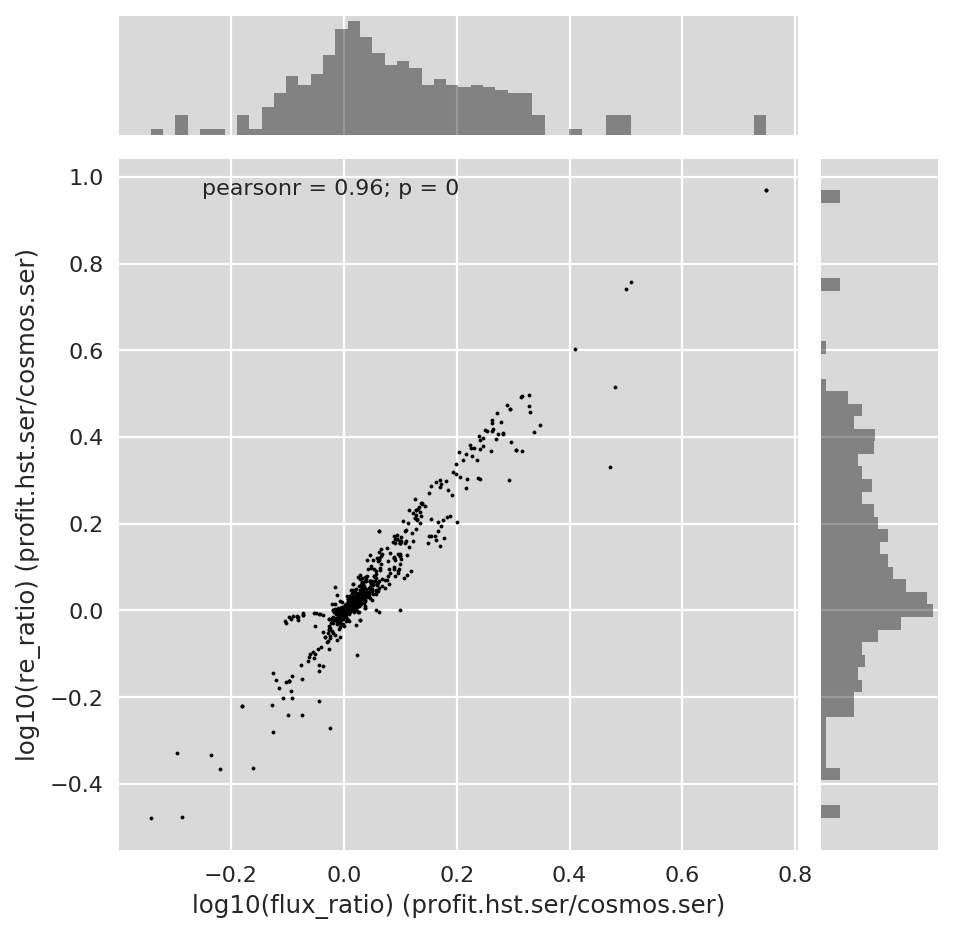

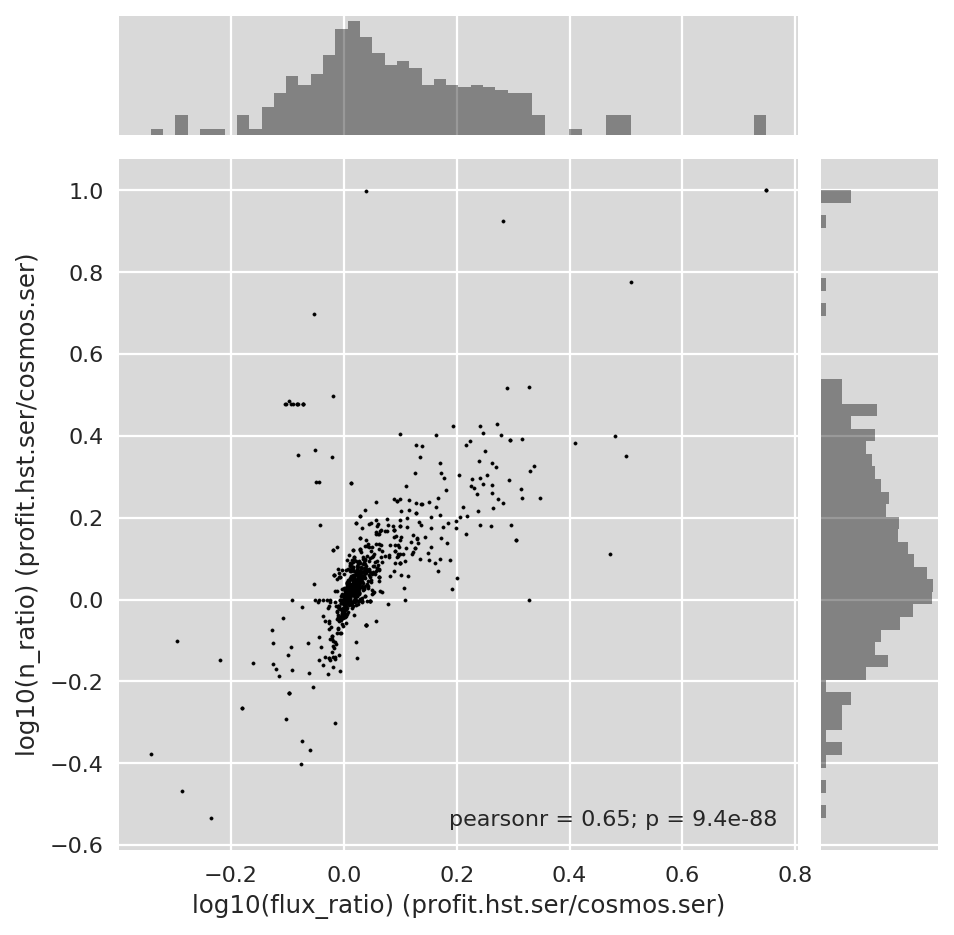

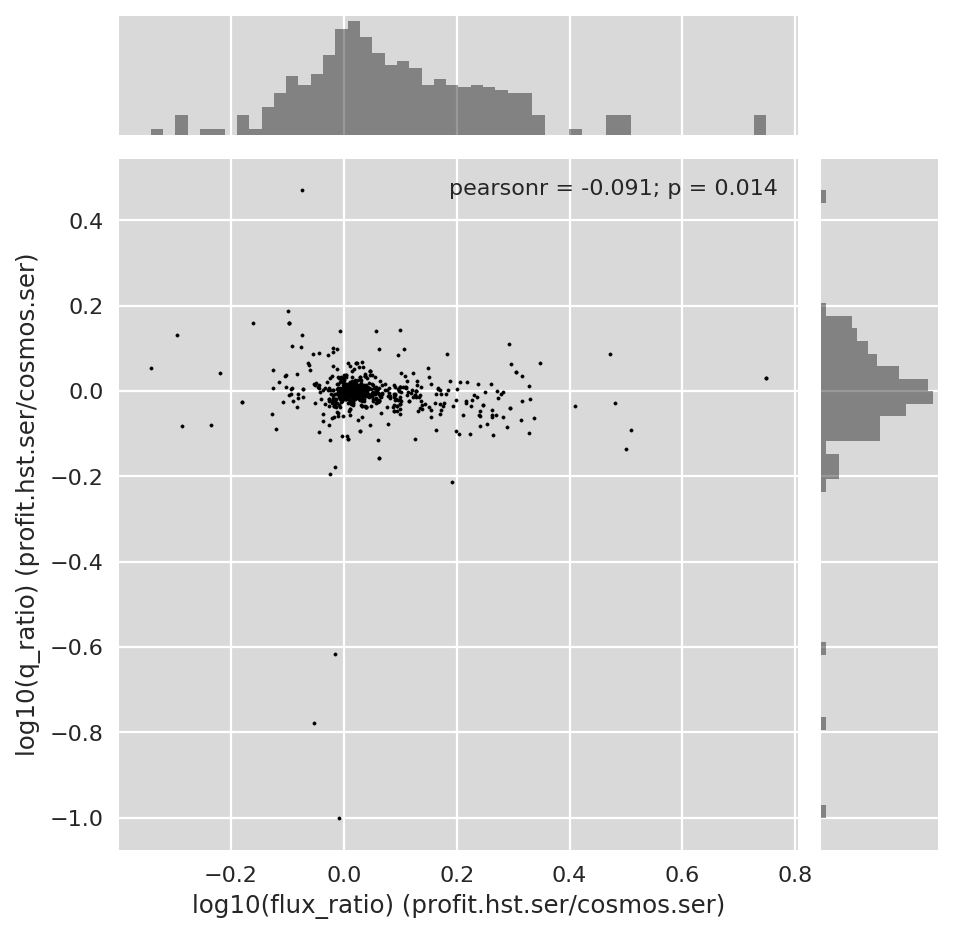

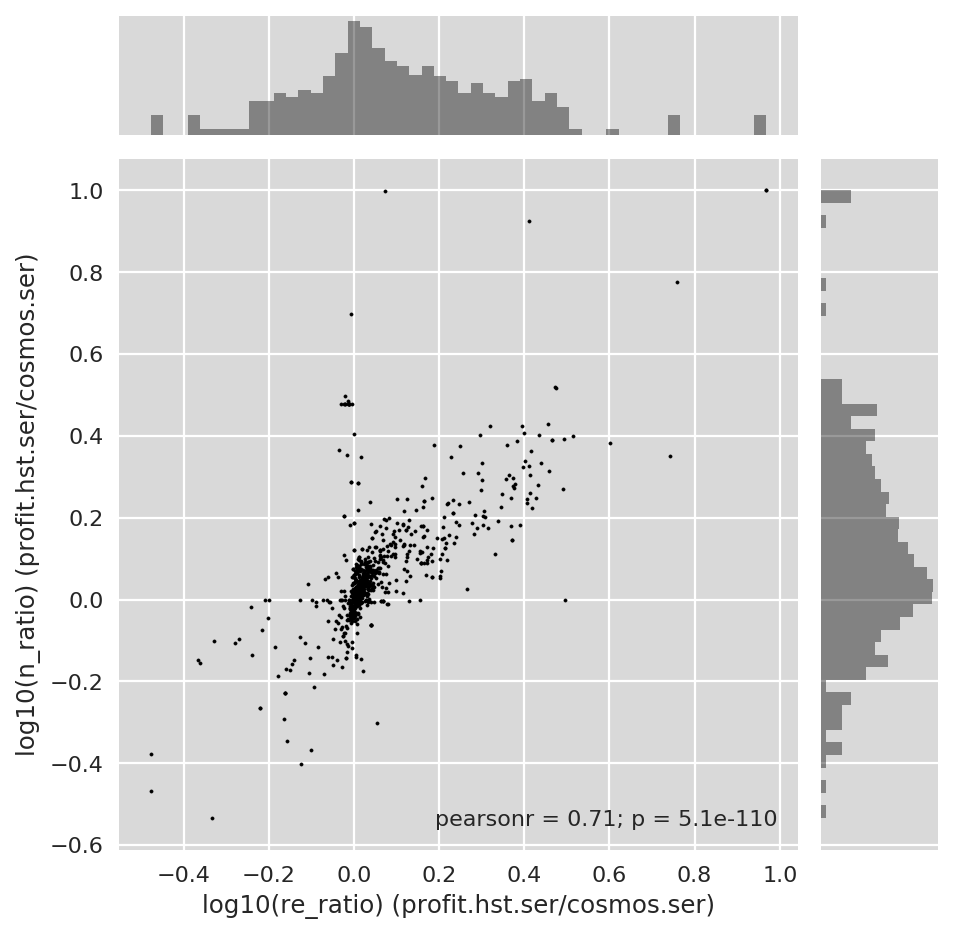

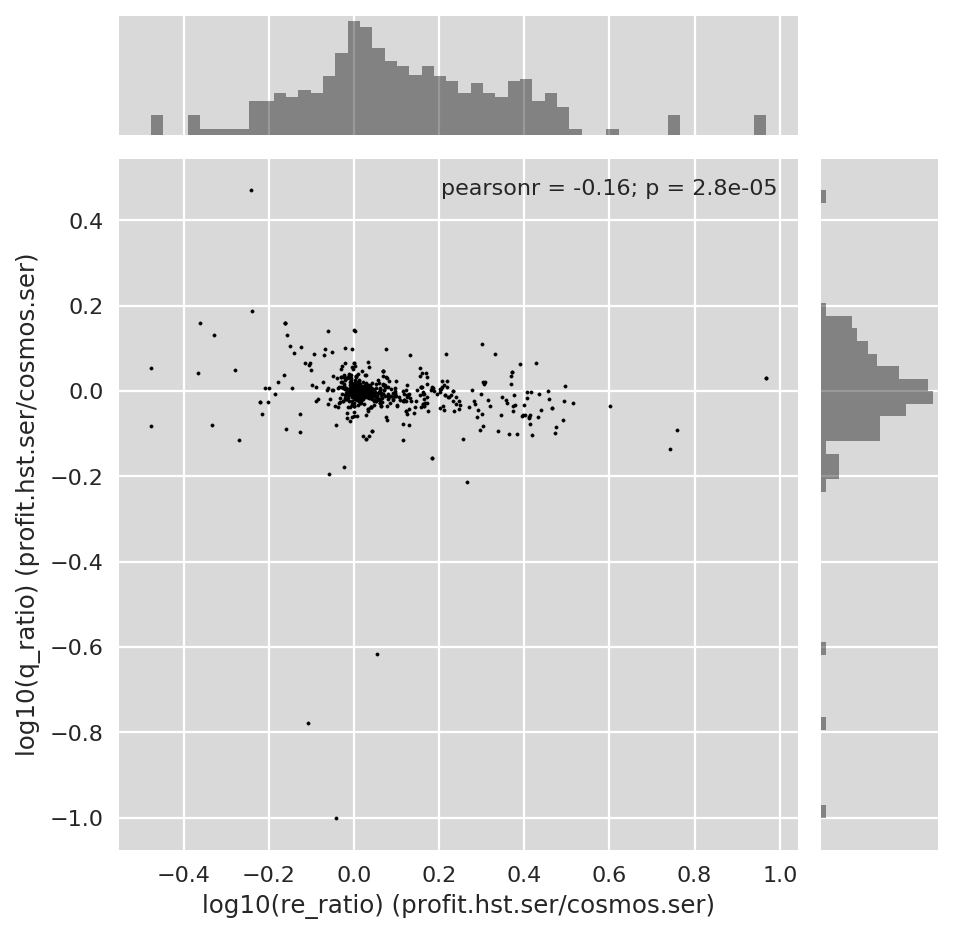

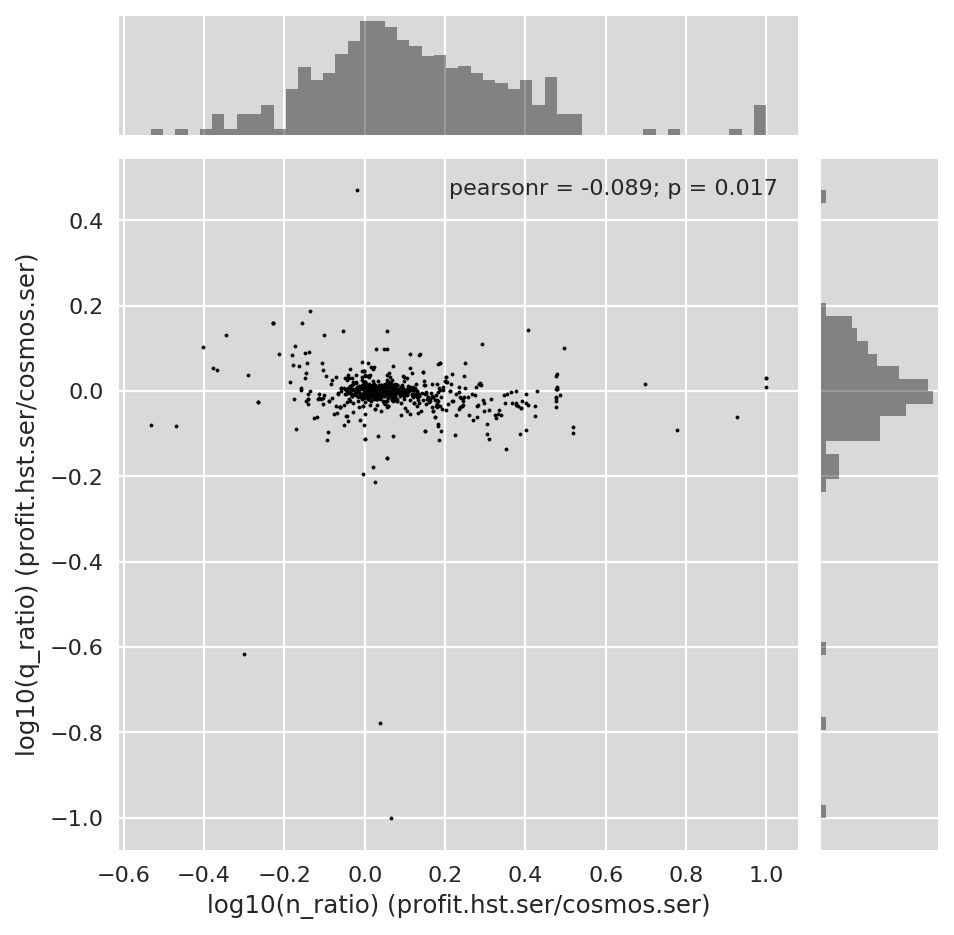

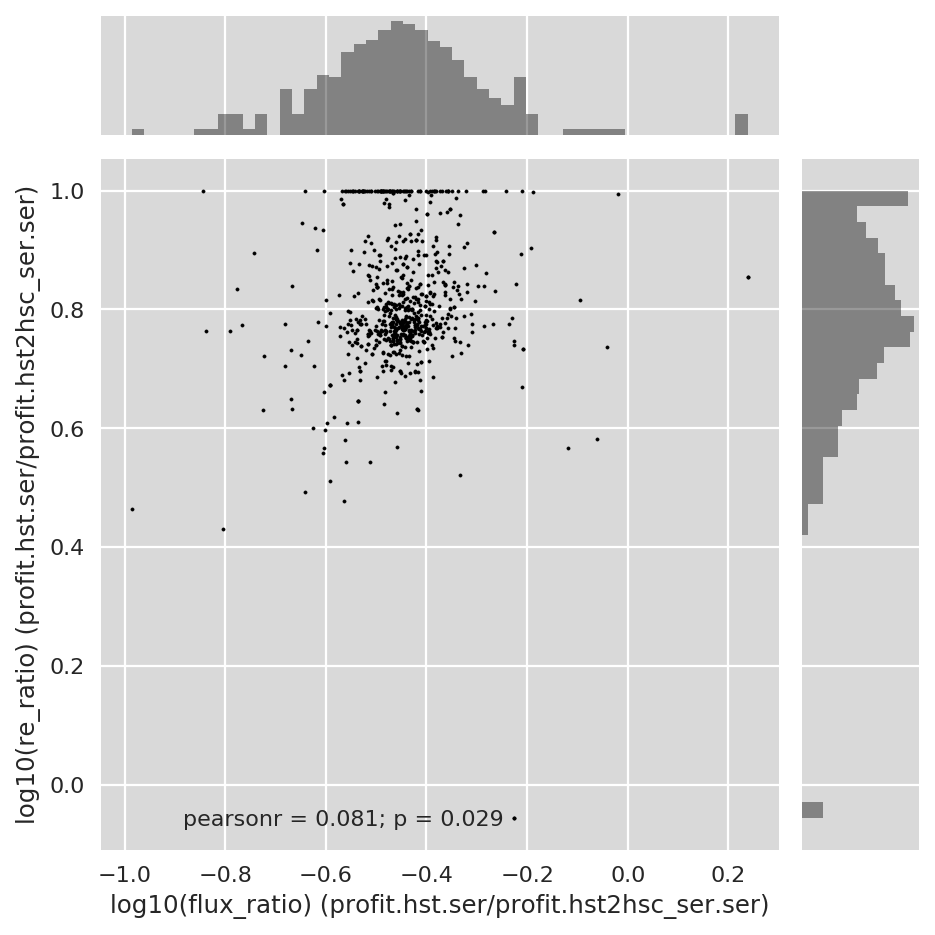

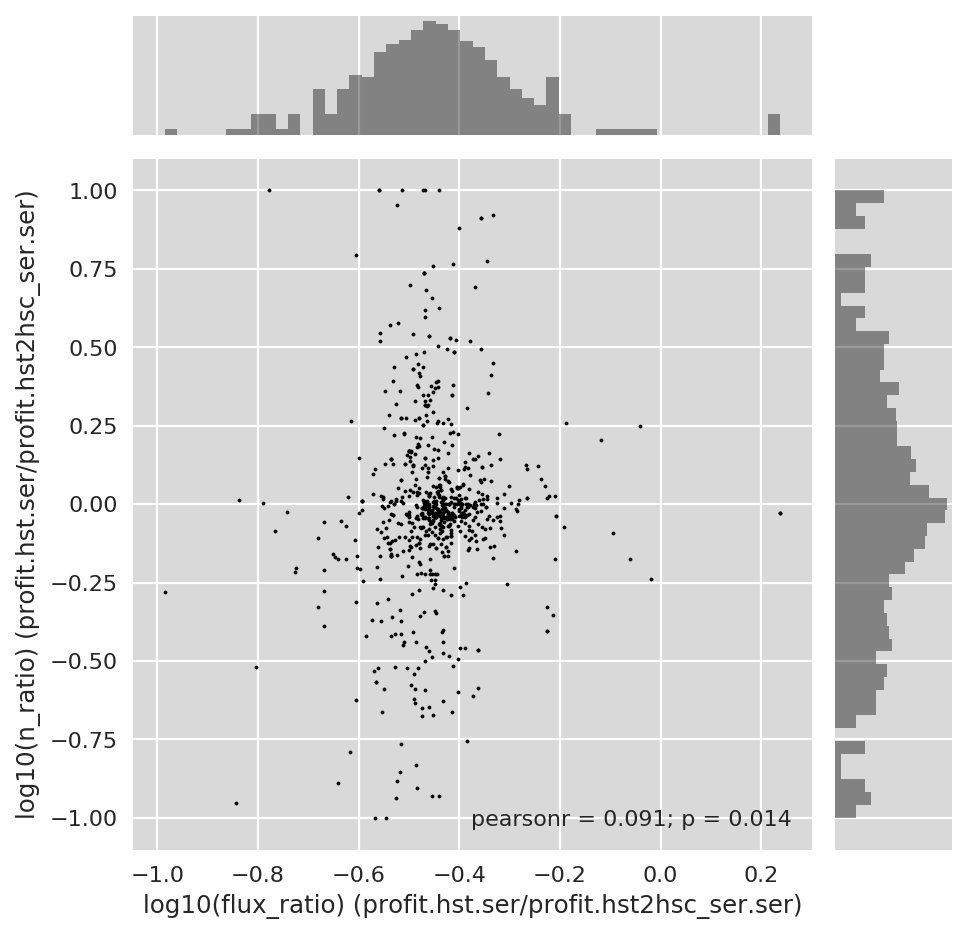

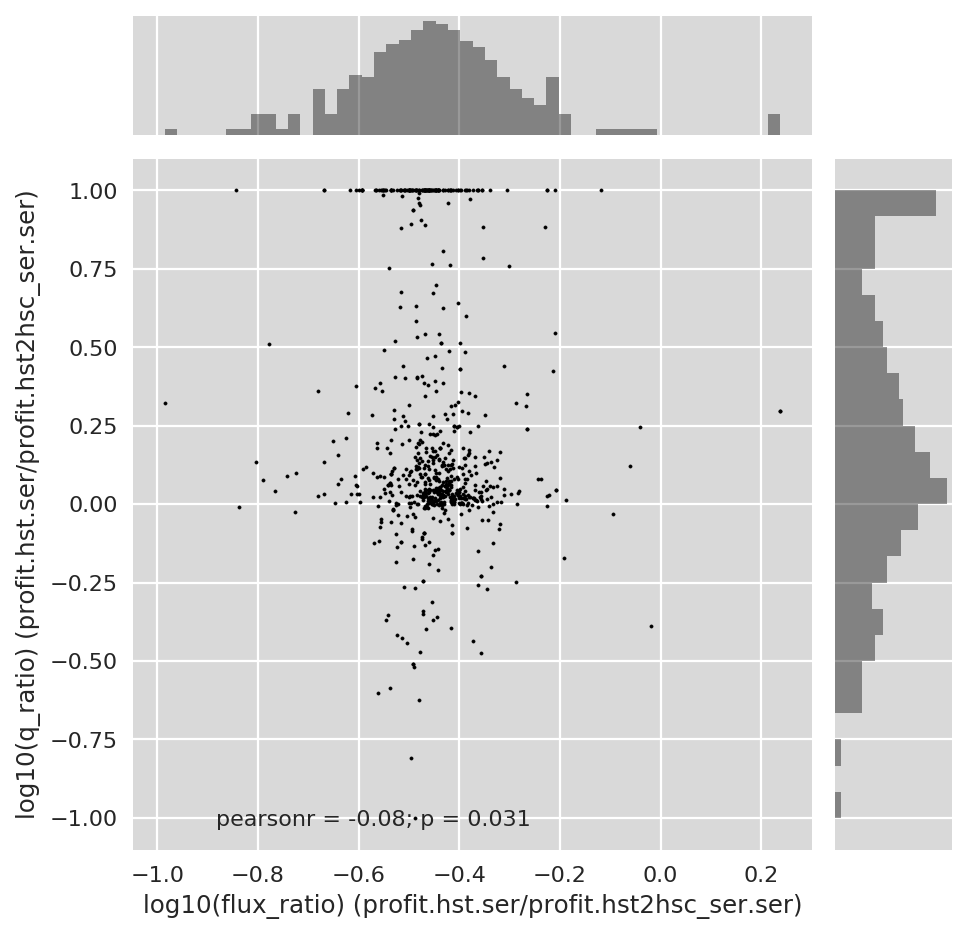

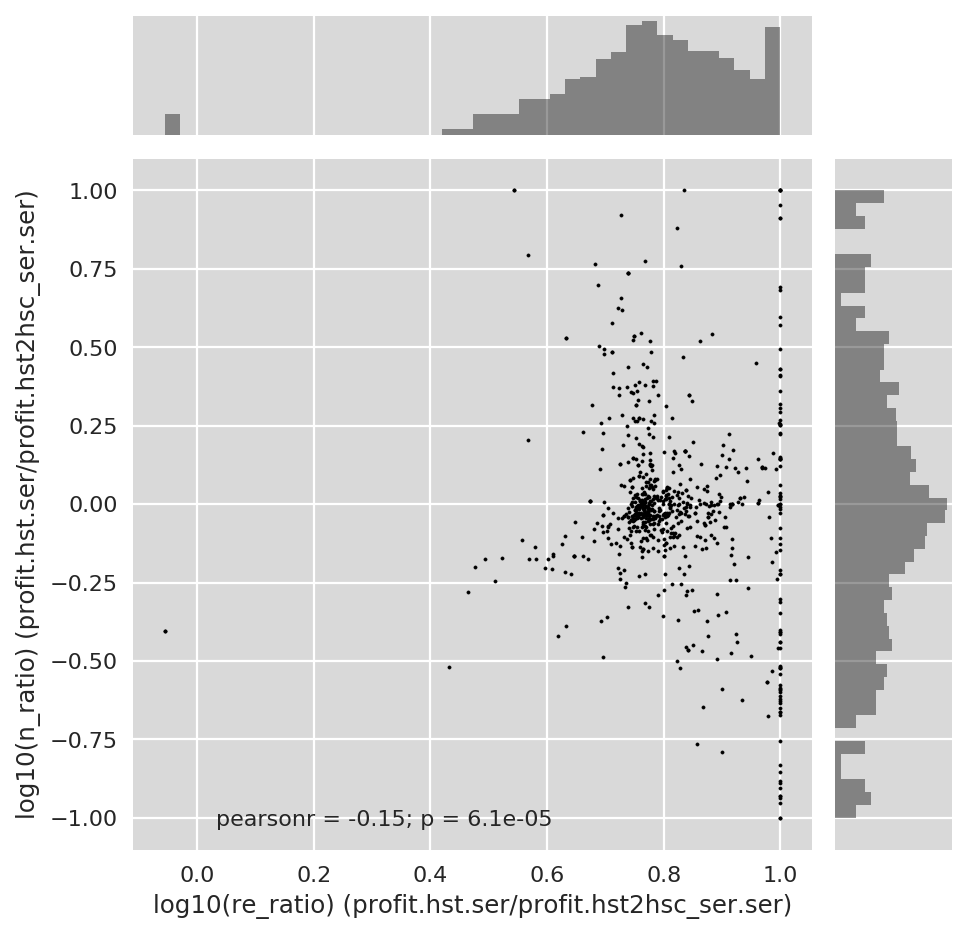

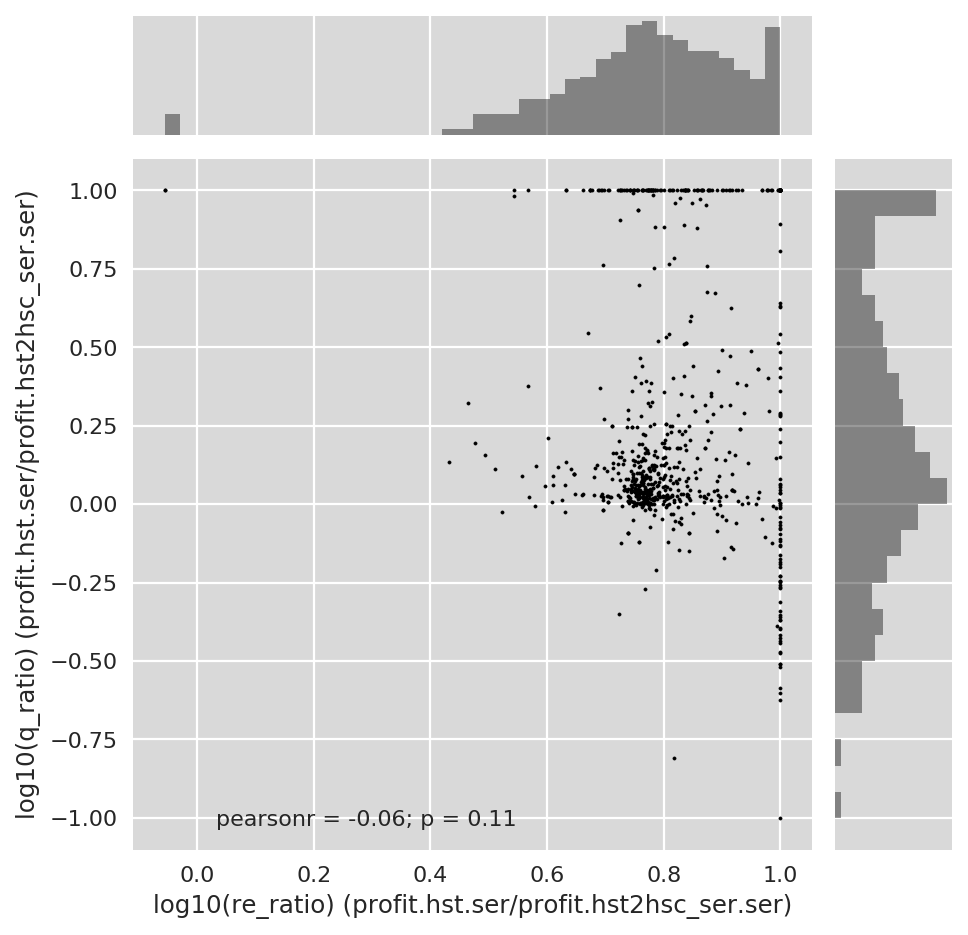

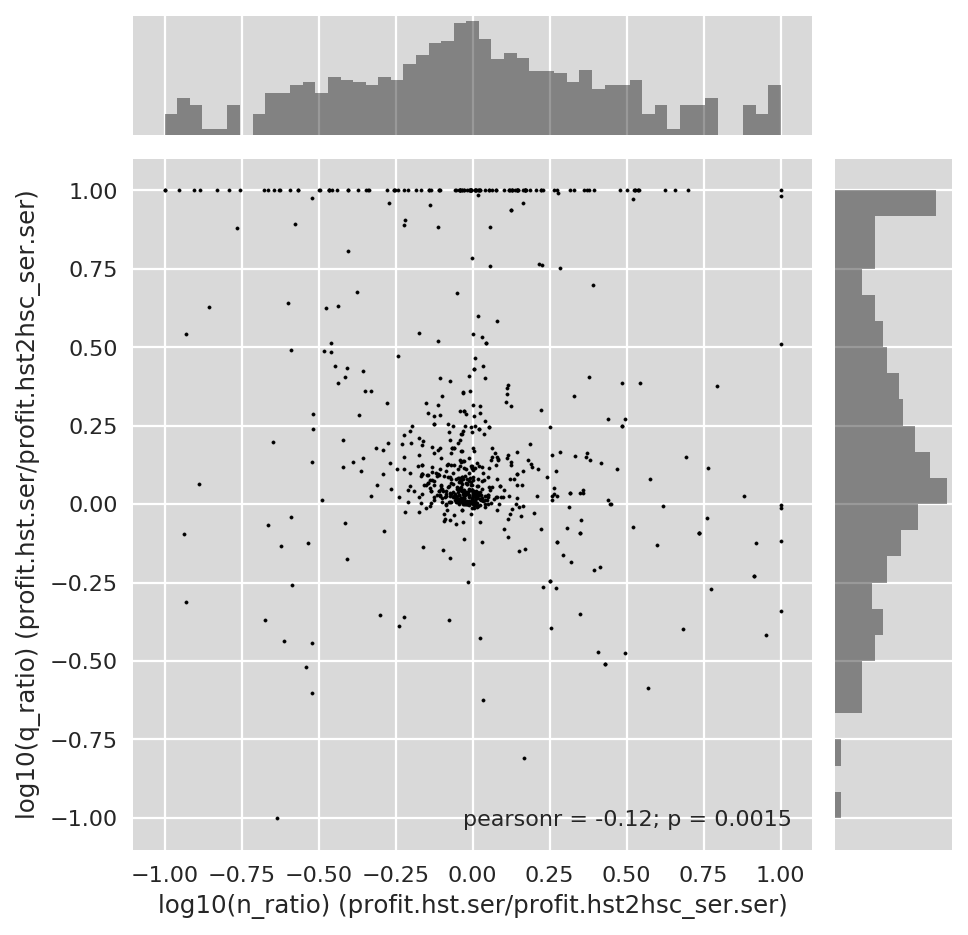

In [11]:
# How well are parameters recovered?
# First check consistency with previous fits (Sersic only for now)
# Then HSC vs HST


varnames = ["flux", "re", "n", "q"]
prefixes = [
    ("profit.hst.ser", "cosmos.ser", varnames),
    ("profit.hst.ser", "profit.hst2hsc_ser.ser", varnames),
#    ("profit.hst.ser", "profit.hst2hsc_devexp.ser", vars),
#    ("profit.hst.ser", "profit.hst2hsc.ser", vars)
]
for prefixx, prefixy, varnames in prefixes:
    ratios = {var: tab[".".join([prefixx, var])]/tab[".".join([prefixy,var])]
              for var in varnames}
    for i, x in enumerate(varnames):
        xlog = np.log10(ratios[x])
        xlog[xlog > 1] = 1
        xlog[xlog < -1] = -1
        for y in varnames[(i+1):(len(varnames)+1)]:
            ylog = np.log10(ratios[y])
            ylog[ylog > 1] = 1
            ylog[ylog < -1] = -1
            fig = sns.jointplot(
                x=xlog,
                y=ylog,
                color="k", joint_kws={'marker': '.', 's': 8},
                marginal_kws={'hist_kws': {'log': True}},
            ).set_axis_labels(
                'log10({}_ratio) ({}/{})'.format(x, prefixx, prefixy),
                'log10({}_ratio) ({}/{})'.format(y, prefixx, prefixy))

profit.devexp.chisqred.1      407
profit.ser.chisqred.1         290
profit.cmodel.chisqred.0       18
profit.gauss.chisqred.1        16
profit.multidev.chisqred.1      5
dtype: int64


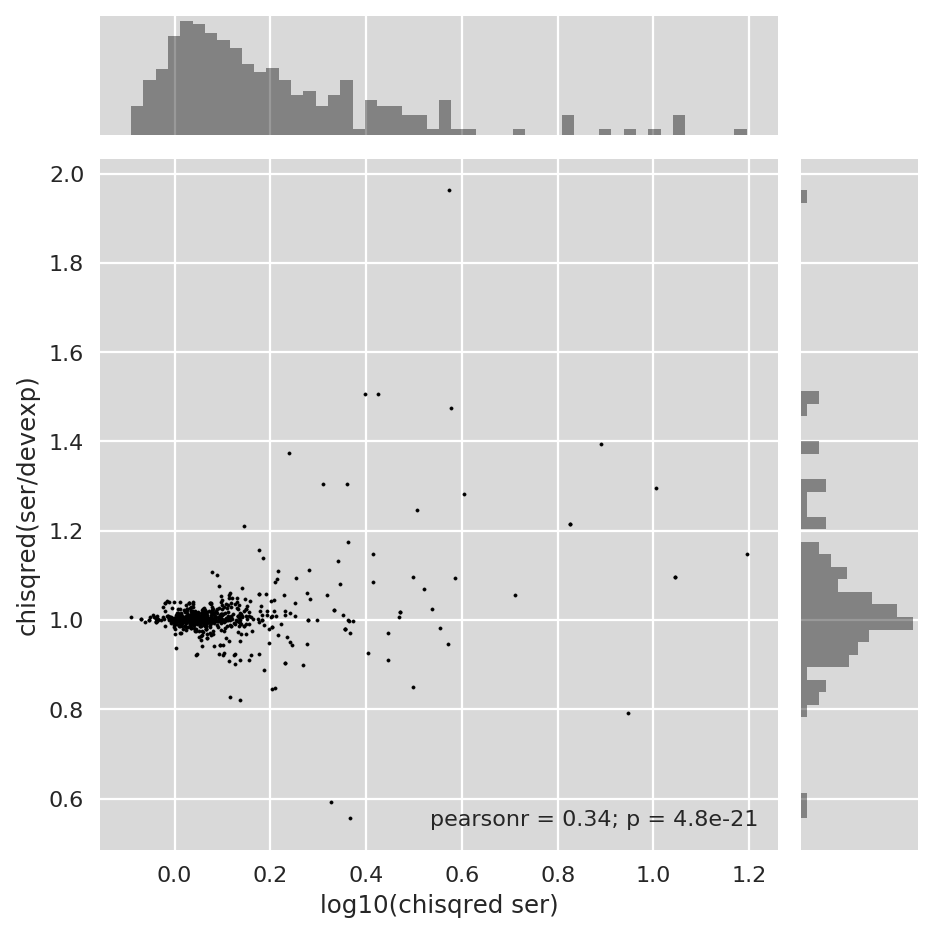

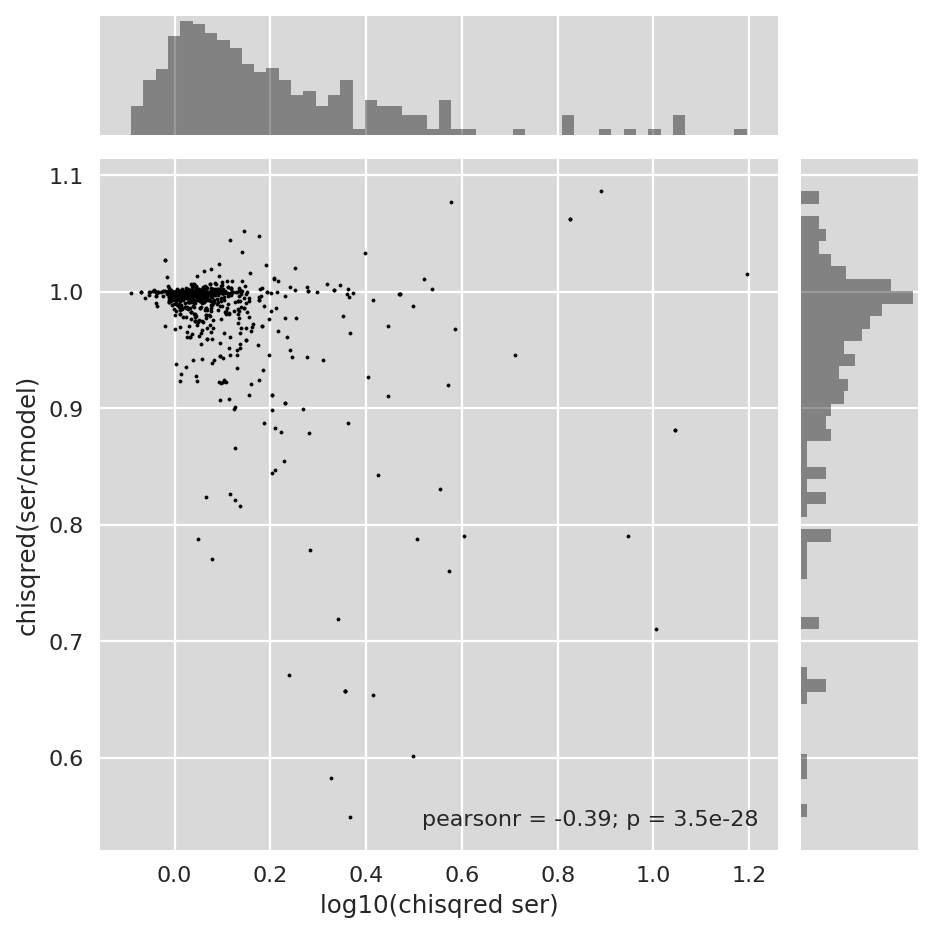

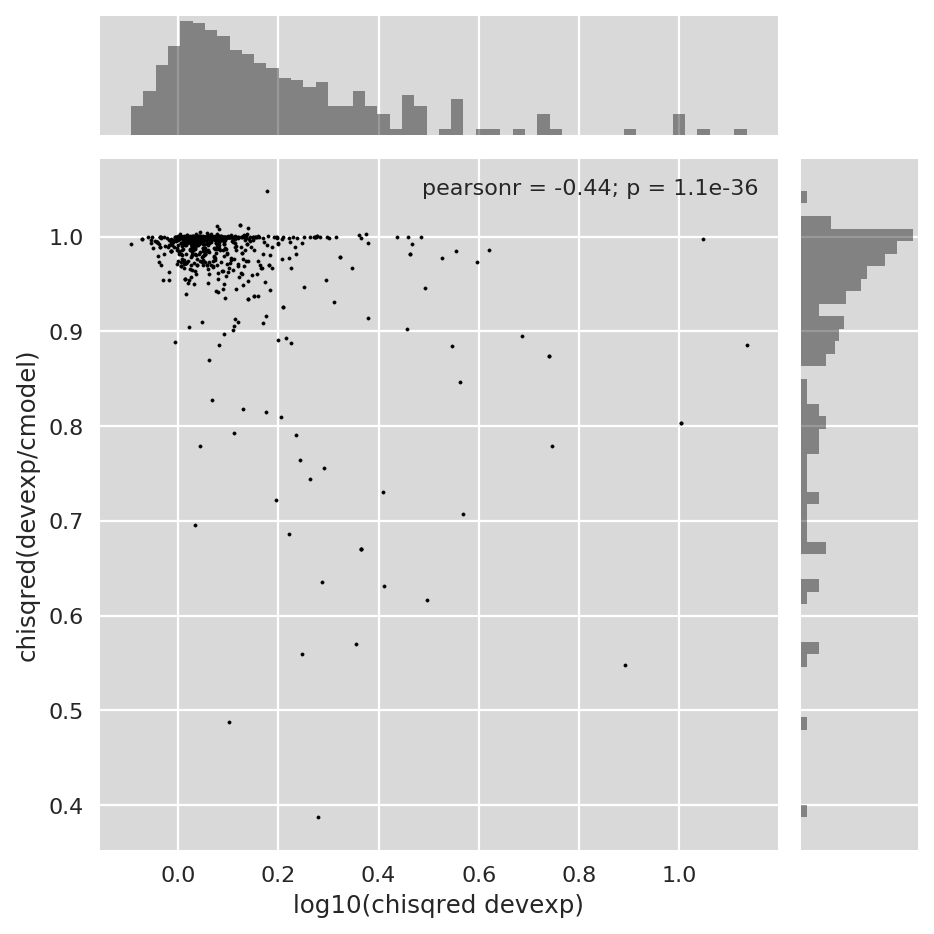

In [58]:
# Which are the best models?
modelsprofit = models["single"]["profit"] + models["double"]["profit"] 
chisqredcols = {
    model: ".".join(["profit", "hst", model, "chisqred",
                     "0" if model == "cmodel" else "1"]) 
    for model in modelsprofit
}
modelbest = tab[list(chisqredcols.values())].idxmin(axis=1)
modelbestcounts = modelbest.value_counts()
print(modelbestcounts)
for colx, coly in [("ser", "devexp"), ("ser", "cmodel"), ("devexp", "cmodel")]:
    sns.jointplot(
        x=np.log10(tab[chisqredcols[colx]]),
        y=tab[chisqredcols[colx]]/tab[chisqredcols[coly]],
        color="k", joint_kws={'marker': '.', 's': 8},
        marginal_kws={'hist_kws': {'log': True}},
    ).set_axis_labels(
        'log10(chisqred {})'.format(colx), 'chisqred({}/{})'.format(colx, coly))